<img src="../images/cads-logo.png" style="height: 100px;" align=left> 
<img src="../images/sklearn-logo.png" style="height: 100px;" align=right>

# Supervised Machine Learning

# Table of Contents

- [Thinking about Model Validation](#Thinking-about-Model-Validation)
- [Cross Validation](#Cross-Validation)
- [Model validation the wrong way](#Model-validation-the-wrong-way)
    - [Question: Can you guess the result of the following cell?](#Question:-Can-you-guess-the-result-of-the-following-cell?)
- [Model validation the right way: Holdout sets](#Model-validation-the-right-way:-Holdout-sets)
- [Model validation via cross-validation](#Model-validation-via-cross-validation)
- [Grid Search](#Grid-Search)

# Thinking about Model Validation

In principle, model validation is very simple: after choosing a model and its hyperparameters, we can estimate how effective it is by applying it to some of the training data and comparing the prediction to the known value.

The following sections first show a naive approach to model validation and why it
fails, before exploring the use of holdout sets and cross-validation for more robust
model evaluation.

# Cross Validation

## Model validation the wrong way

Let's demonstrate the naive approach to validation using the Iris data, which we saw in the previous section. We will start by loading the data:

In [136]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

In [137]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (150, 4)
Shape of y: (150,)


Next we choose a model and hyperparameters. Here we'll use a *k*-neighbors classifier with ``n_neighbors=1``.
This is a very simple and intuitive model that says "the label of an unknown point is the same as the label of its closest training point:"

<img src='../images/KNN.png'>

In [138]:
from sklearn.neighbors import KNeighborsClassifier
model= KNeighborsClassifier(n_neighbors=1)

Then we train the model, and use it to predict labels for data we already know:

In [139]:
model.fit(X, y)
y_model = model.predict(X)

Finally, we compute the fraction of correctly labeled points:

### Question: Can you guess the result of the following cell?

In [140]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

We see an accuracy score of 1.0, which indicates that 100% of points were correctly labeled by our model!
But is this truly measuring the expected accuracy? Have we really come upon a model that we expect to be correct 100% of the time?

As you may have gathered, the answer is no.
In fact, this approach contains a fundamental flaw: *it trains and evaluates the model on the same data*.
Furthermore, the nearest neighbor model is an *instance-based* estimator that simply stores the training data, and predicts labels by comparing new data to these stored points: except in contrived cases, it will get 100% accuracy *every time!*

## Model validation the right way: Holdout sets

So what can be done?
A better sense of a model's performance can be found using what's known as a *holdout set*: that is, we hold back some subset of the data from the training of the model, and then use this holdout set to check the model performance.
This splitting can be done using the ``train_test_split`` utility in Scikit-Learn:

In [141]:
print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [142]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# split the data with 50% in each set
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0,train_size=0.5)

#fit the model
model.fit(X_train, y_train)

# fit and evaluate the model on the second set of data
y_model = model.predict(X_test)

accuracy_score(y_test, y_model)

0.9066666666666666

In [143]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(75, 4)
(75,)
(75, 4)
(75,)


We see here a more reasonable result: the nearest-neighbor classifier is about 90% accurate on this hold-out set.
The hold-out set is similar to unknown data, because the model has not "seen" it before.

## Model validation via cross-validation

One disadvantage of using a holdout set for model validation is that we have lost a portion of our data to the model training.
In the above case, half the dataset does not contribute to the training of the model!
This is not optimal, and can cause problems – especially if the initial set of training data is small.

![](../images/2-fold-CV.png)

One way to address this is to use *cross-validation*; that is, to do a sequence of fits where each subset of the data is used both as a training set and as a validation set.
Visually, it might look something like this:

Here we do two validation trials, alternately using each half of the data as a holdout set.
Using the split data from before, we could implement it like this:

**Question:**
Write the code that implements the accuracy described on the previous image

In [144]:
# solution
y1_model = model.fit(X_train, y_train).predict(X_test)
y2_model = model.fit(X_test, y_test).predict(X_train)
accuracy_score(y_test, y1_model), accuracy_score(y_train, y2_model)

(0.9066666666666666, 0.96)

What comes out are two accuracy scores, which we could combine (by, say, taking the mean) to get a better measure of the global model performance.
This particular form of cross-validation is a *two-fold cross-validation*—that is, one in which we have split the data into two sets and used each in turn as a validation set.

We could expand on this idea to use even more trials, and more folds in the data—for example, here is a visual depiction of five-fold cross-validation:

<img src='../images/CV.png'/>

Here we split the data into five groups, and use each of them in turn to evaluate the model fit on the other 4/5 of the data.
This would be rather tedious to do by hand, and so we can use Scikit-Learn's ``cross_val_score`` convenience routine to do it succinctly:

In [145]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=3)    # cv by default is 3-fold 
scores

array([0.98039216, 0.92156863, 1.        ])

In [146]:
print("Accuracy: {}".format(scores.mean()))

Accuracy: 0.9673202614379085


By default, the score computed at each cv iteration is the `score` method of the estimator. It is possible to change this by using the scoring parameter. Take a look at all possible values for [scoring parameter](https://scikit-learn.org/stable/modules/model_evaluation.html).


In [147]:
scores_f1 = cross_val_score(model, X, y, cv=2, scoring='f1_macro')   
scores_f1

array([0.94666667, 0.9465812 ])

Repeating the validation across different subsets of the data gives us an even better idea of the performance of the algorithm.

Scikit-Learn implements a number of useful cross-validation schemes that are useful in particular situations; these are implemented via iterators in the ``cross_validation`` module.
For example, we might wish to go to the extreme case in which our number of folds is equal to the number of data points: that is, we train on all points but one in each trial.
This type of cross-validation is known as *leave-one-out* cross validation, and can be used as follows:

In [148]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Because we have 150 samples, the leave one out cross-validation yields scores for 150 trials, and the score indicates either successful (1.0) or unsuccessful (0.0) prediction.
Taking the mean of these gives an estimate of the error rate:

In [149]:
scores.mean()

0.96

Other cross-validation schemes can be used similarly.
For a description of what is available in Scikit-Learn, use IPython to explore the ``sklearn.cross_validation`` submodule, or take a look at Scikit-Learn's online [cross-validation documentation](http://scikit-learn.org/stable/modules/cross_validation.html).

**Exercise:**
Try to classify Iris data using KNN for n_neighbors=5. Use 3-fold cross validation and use Accuracy, Precision, Recall, F1-score as evaluation metrics.

In [150]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

### Your code here

In [151]:
model= KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [152]:
from sklearn.model_selection import cross_val_score
scores_acc = cross_val_score(model, X, y, cv=3)    # cv by default is 3-fold 
scores_f1 = cross_val_score(model, X, y, cv=3,scoring='f1_macro')   
scores_prec = cross_val_score(model, X, y, cv=3,scoring='precision_macro') 
scores_rec = cross_val_score(model, X, y, cv=3,scoring='recall_macro')

print("Accuracy: {}".format(scores_acc.mean()))
print("F1: {}".format(scores_f1.mean()))
print("Precision: {}".format(scores_prec.mean()))
print("Recall: {}".format(scores_rec.mean()))

Accuracy: 0.9869281045751634
F1: 0.9869167869167871
Precision: 0.9876543209876543
Recall: 0.9869281045751634


In [153]:
# MC
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

scores_accuracy =cross_val_score(knn, X, y, cv=3)
print('Mean of Accuracy: {}'.format(np.mean(scores_accuracy)))

scores_f1 = cross_val_score(knn, X, y, cv=3, scoring='f1_macro') 
print('Mean of F1: {}'.format(np.mean(scores_f1)))

scores_precision = cross_val_score(knn, X, y, cv=3, scoring='precision_macro')
print('Mean of Precision: {}'.format(np.mean(scores_precision)))

scores_recall = cross_val_score(knn, X, y, cv=3, scoring='recall_macro') 
print('Mean of Recall: {}'.format(np.mean(scores_recall)))

Mean of Accuracy: 0.9869281045751634
Mean of F1: 0.9869167869167871
Mean of Precision: 0.9876543209876543
Mean of Recall: 0.9869281045751634


# Grid Search
Grid search is the process of performing hyper parameter tuning in order to determine the optimal values for a given model. Scikit-Learn provides automated tools to do this in the grid search module.

Here is an example of using grid search to find the optimal polynomial model. We will explore a three-dimensional grid of model features; namely the polynomial degree, the flag telling us whether to fit the intercept, and the flag telling us whether to normalize the problem. This can be set up using Scikit-Learn's ``GridSearchCV`` meta-estimator:

Now let's create some data to which we will fit our model:


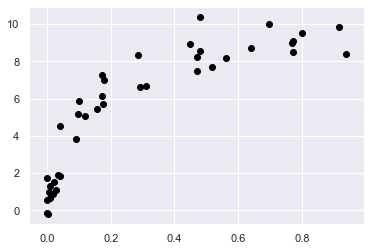

In [154]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')

In [155]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [156]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

In [157]:
21 * 2 * 2

84

Notice that like a normal estimator, this has not yet been applied to any data.
Calling the ``fit()`` method will fit the model at each grid point, keeping track of the scores along the way:

In [158]:
grid.fit(X, y);

D:\Users\Faiz\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Now that this is fit, we can ask for the best parameters as follows:

In [159]:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

In [160]:
grid

GridSearchCV(cv=7, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('linearregression',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'linearregression__fit_intercept': [True, False],
                        

Finally, if we wish, we can use the best model and show the fit to our data using code from before:

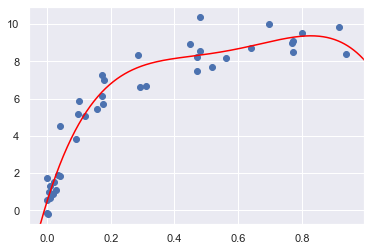

In [161]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_pred = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_pred, color = 'red');
plt.axis(lim);

The grid search provides many more options, including the ability to specify a custom scoring function, to parallelize the computations, to do randomized searches, and more.

## Exercise:

Load the cancer dataset and choose the best classification algorithm with the best hyperparameters.

- Define X and y

- To simplify, remove missing values

- Split data to train and test

- Use 5 fold cross validation and grid search on train data

- Choose appropriate validation metric

- Set grid parameters for each classification algorithm

- Build the best models for each classification algorithm according to the best estimator (best hyperparameters) given by the grid search

- Compare the performance of the algorithms with the best hyperparametrs on the test data according to confusion matrix, recall, precision, F1, and auc metrics

In [162]:
df = pd.read_csv('../Data/breast_cancer_wisconsin.csv')

In [163]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [164]:
### Your code here

In [165]:
df.isna().sum()

Id                  0
Cl.thickness        0
Cell.size           0
Cell.shape          0
Marg.adhesion       0
Epith.c.size        0
Bare.nuclei        16
Bl.cromatin         0
Normal.nucleoli     0
Mitoses             0
Class               0
dtype: int64

In [166]:
df = df.dropna()
df

,Id,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,0
1,1002945,5,4,4,5,7,10.0,3,2,1,0
2,1015425,3,1,1,1,2,2.0,3,1,1,0
3,1016277,6,8,8,1,3,4.0,3,7,1,0
4,1017023,4,1,1,3,2,1.0,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2.0,1,1,1,0
695,841769,2,1,1,1,2,1.0,1,1,1,0
696,888820,5,10,10,3,7,3.0,8,10,2,1
697,897471,4,8,6,4,3,4.0,10,6,1,1


In [167]:
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]
X.head()

,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses
0,5,1,1,1,2,1.0,3,1,1
1,5,4,4,5,7,10.0,3,2,1
2,3,1,1,1,2,2.0,3,1,1
3,6,8,8,1,3,4.0,3,7,1
4,4,1,1,3,2,1.0,3,1,1


In [168]:
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (683, 9)
Shape of y: (683,)


In [169]:
# Split data to train and test

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)


In [170]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(512, 9)
(512,)
(171, 9)
(171,)


**Knn**

In [171]:
### Your code here

In [175]:
knn_param_grid = {'n_neighbors': np.arange(1, 30),
                  'p': np.arange(1,3)}

knn_grid = GridSearchCV(KNeighborsClassifier(metric='minkowski'), 
                        knn_param_grid, cv=5, scoring = 'roc_auc', return_train_score=True)

knn_grid.fit(X_train, y_train)
print('Knn Best parameters', knn_grid.best_params_)
knn_model = knn_grid.best_estimator_
print('Knn best score = ',knn_grid.best_score_ )


Knn Best parameters {'n_neighbors': 22, 'p': 2}
Knn best score =  0.992192956648611


In [186]:
# MC
knn_param_grid = {'n_neighbors': np.arange(1, 30),
                  'p': np.arange(1,3)}

knn_grid = GridSearchCV(KNeighborsClassifier(metric='minkowski'), 
                        knn_param_grid, cv=5, scoring = 'roc_auc', return_train_score=True)

knn_grid.fit(X_train, y_train)
print('Knn Best parameters', knn_grid.best_params_)
knn_model = knn_grid.best_estimator_
print('Knn best score = ',knn_grid.best_score_ )


Knn Best parameters {'n_neighbors': 22, 'p': 2}
Knn best score =  0.992192956648611


**Decision Tree**

In [ ]:
### Your code here

In [177]:
from sklearn.tree import DecisionTreeClassifier

dt_param_grid = {'max_depth': np.arange(1,10)}

dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=1), 
                        dt_param_grid, cv=5, scoring = 'roc_auc', return_train_score=True)

dt_grid.fit(X_train, y_train)
print('Knn Best parameters', dt_grid.best_params_)
dt_model = knn_grid.best_estimator_
print('Knn best score = ',dt_grid.best_score_ )


Knn Best parameters {'max_depth': 3}
Knn best score =  0.9630088401382009


**Logistic Regression**

In [ ]:
### Your code here

In [178]:
# MC
logr_param_grid = {'C': np.logspace(-3,3,10),
                   'penalty' : ['l1', 'l2'],
                   'solver': ['liblinear'],
                   'fit_intercept': [True, False]}

logr_grid = GridSearchCV(LogisticRegression(), 
                        logr_param_grid, cv=5, scoring = 'roc_auc', return_train_score=True)
logr_grid.fit(X_train, y_train)
print('LogisticRegression Best parameters', logr_grid.best_params_)
logr_model = logr_grid.best_estimator_
print('LogisticRegression best score = ',logr_grid.best_score_ )

LogisticRegression Best parameters {'C': 0.46415888336127775, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
LogisticRegression best score =  0.994574474495955


**Support Vector Machine (SVM)**

In [ ]:
### Your code here

In [182]:
# MC
svc_param_grid = {'C': [0.1,1,10,100],
                  'kernel' : ['linear', 'rbf', 'poly', 'sigmoid'],
                  'gamma': [1,0.1,0.01,0.001],
                  'degree': np.arange(1,11)}

svc_grid = GridSearchCV(SVC(), 
                        svc_param_grid, cv=5, scoring = 'roc_auc', return_train_score=True)
svc_grid.fit(X_train, y_train)
print('LogisticRegression Best parameters', svc_grid.best_params_)
svc_model = svc_grid.best_estimator_
print('LogisticRegression best score = ',svc_grid.best_score_ )

LogisticRegression Best parameters {'C': 1, 'degree': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}
LogisticRegression best score =  0.9964387620719929


D:\Users\Faiz\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


**Compare the best models on the test data**

In [ ]:
### Your code here

In [191]:
# MC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

knn_pred = knn_model.predict(X_test)
print('Knn best model confusion matrix on test data  \n',confusion_matrix(y_test, knn_pred)  )
print('*********************************************')
print('Knn best model Precision  on test data = {:.2f}'.format(precision_score(y_test, knn_pred)))
print('Knn best model Recall  on test data = {:.2f}'.format(recall_score(y_test, knn_pred)))
print('Knn best model F1 on test data = {:.2f}'.format(f1_score(y_test, knn_pred)))
print('Knn best model Accuracy  on test data = {:.2f}'.format(accuracy_score(y_test, knn_pred)))
print('*********************************************')

Knn best model confusion matrix on test data  
 [[104   3]
 [  9  55]]
*********************************************
Knn best model Precision  on test data = 0.95
Knn best model Recall  on test data = 0.86
Knn best model F1 on test data = 0.90
Knn best model Accuracy  on test data = 0.93
*********************************************


In [192]:
# Repeat for other model